<a href="https://colab.research.google.com/github/nabinyd/60-Days-of-learning/blob/main/DLPT_06_PyTorch__Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 33

## Transfer Learning OverView

**Transfer Learning** is a machine learning technique where a model developed for a particular task is reused as the starting point for a model on a second task. This approach leverages pre-trained models on large datasets, typically for task like image classification or natural language processing (NLP) , and fine-tunes then for specific, often smaller related tasks. This method is highly efficient, both in terms of computational resources and time, compared to training a model from scratch.

Imagine you're learning a new sport. if you already know how to play a similar sport, you'll likely pick up the new one faster. Transfer learning works in a similar way for machines.


**Key Concepts**:

1. **Pre-trained models**: Models that have been previously trained on a large dataset and are used as the foundation for a new, related task.

2. **Fine-tuning**: Adjusting the pre-trained model's parameter's for the specific target task.

3. **Feature extraction**: Using the pre-trained model's layers to extract features from new data without modifying the weights of these layers.

4. **Base Model**: The original pre-trained model before any fine-tuning or modification for a new task








### **Why use Transfer learning?**

1. **Efficiency**: Reduces training time significantly as the model has already learned useful features from the large dataset.

2. **Performance**: Often yields better performance, especially when the target dataset is small or similar to the dataset the model was originally trained on.

3. **Resource Utilization**: Makes effective use of computational resources, as training a  model from scratch can be highly resource-intensive.

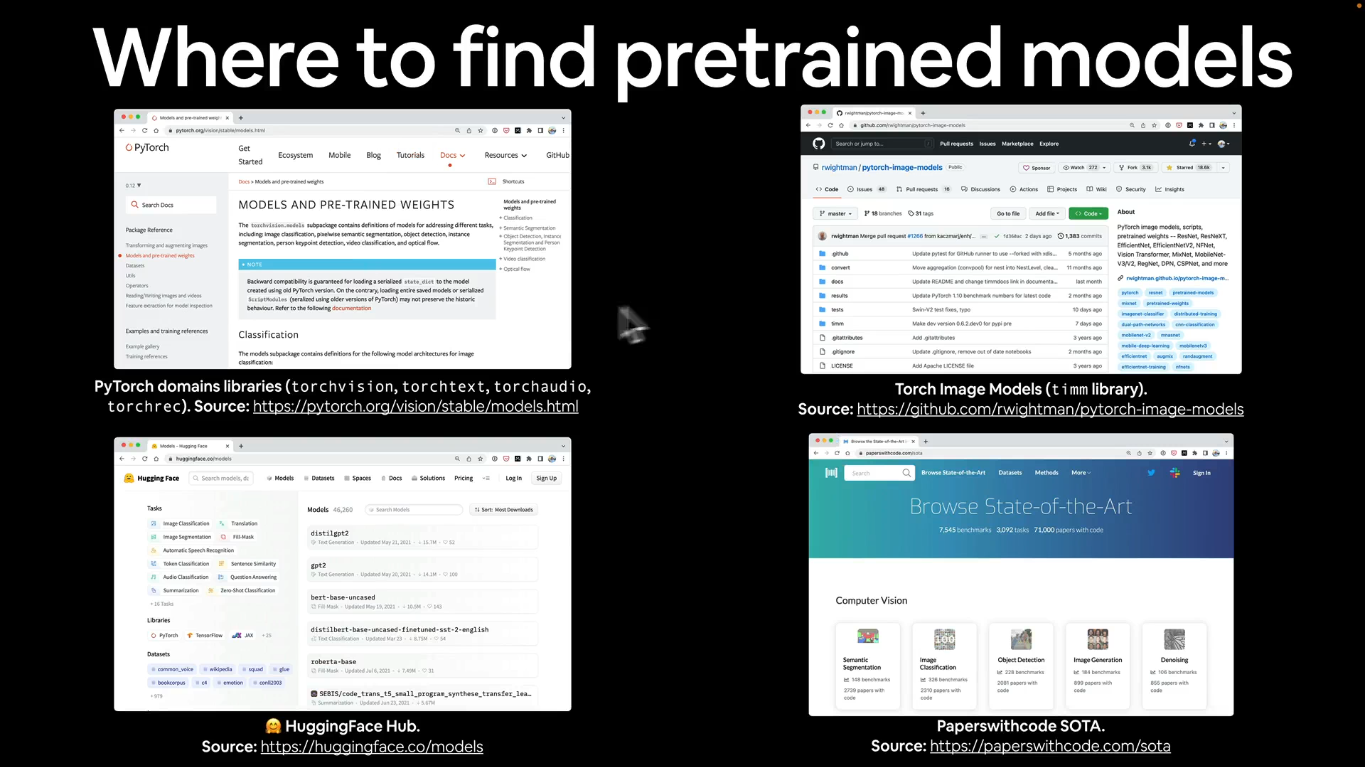

## **What we are going to cover?**

  * Getting setup (importing previously written code)
  * Introduce transfer learning with PyTorch
  * Customise a pretrained model for our own use case (FoodVision mini)
  * Evaluating a transfer learning model
  * Making a transfer learning model
  * Making predictions on our own custom data

In [2]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [3]:
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Coudn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going _modular directory, download it from github if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
except:
  # Get the going_modular scripts
  print("[INFO] Coudn't find going_modular scripts... downloading them from github." )
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  # !rm -rf pytorch-deep-learning
  # from going_modular.going_modular import data_setup, engine

[INFO] Coudn't find torchinfo... installing it.
[INFO] Coudn't find going_modular scripts... downloading them from github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [4]:
!rm -rf pytorch-deep-learning

In [5]:
from going_modular.going_modular import data_setup, engine

In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data
We need our pizaa, steak, sushi data to build a transfer learning model on.


In [7]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [8]:
# setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Day 34

## 2. Create Datrasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.
To do so, we can use `data_setup.py` and `create_dataloaders()` function we made in 05.PyTorch_ going _modular


There's one thing we have to think about when loading: how to **transform** it?

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.


**Important point:** When using a pretrained model, it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

In [10]:
from going_modular.going_modular import data_setup


### 2.1  Creating a transform for `torchvision.models` (manaul creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right wihtin `torchvision`.

In [11]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),   # resize image to 224, 224 (height * width)
    transforms.ToTensor(),   # get images into range [0, 1]
    normalize  # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)
])

In [12]:
from going_modular.going_modular import data_setup
train_dataloader, test_datalaoder, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_datalaoder, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e131ebddae0>,
 ['pizza', 'steak', 'sushi'])

 ### 2.2 Creating a transform for `torchvision.models` (auto creation)



In [ ]:
import torchvision
